<a href="https://colab.research.google.com/github/PedrinHm/RN_Twittes_Toxicos/blob/main/Analisador_twittes_toxico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Utilizando Rede Neural Recorrente do tipo LSTM (Long Short Term Memory) para classificar sentimentos em Twittes.**



**Metas:**
- Carregar os reviews de filmes do  IBDb (~50.0000)
- Pré-processsar o dataset removendo caracteres especiais, números e converter os labels de sentimento de pos/neg para respectivamente 1 e 0
- Importar o GloVe Word Embedding, um dicionário para construção de uma matriz de Embedding
- Criar nosso modelo LSTM e treinar a rede
- Avaliar os resultados
- Realizar predições


In [73]:
# Montando o google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [74]:
# Definindo diretório de trabalho

%cd /content/drive/My Drive/twittes_toxicos/
! ls

/content/drive/My Drive/twittes_toxicos
glove_s100.txt	lstm_model_acc_0.564.h5  ToLD-BR.csv


In [75]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [76]:
#Importações de Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from numpy import array
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding, LSTM, Flatten, Dense

In [77]:
#Carregando Dataset

twitte_reviews = pd.read_csv("ToLD-BR.csv")

In [78]:
#Exploração do Dataset

twitte_reviews.shape

(21000, 7)

In [103]:
twitte_reviews.head(15)

,text,homophobia,obscene,insult,racism,misogyny,xenophobia,soma,classificacao,classificacao_label
0,Meu nivel de amizade com isis é ela ter meu in...,0.0,0.0,2.0,0.0,0.0,0.0,2.0,negativo,Negativo
1,"rt @user @user o cara adultera dados, que fora...",0.0,0.0,1.0,0.0,0.0,0.0,1.0,negativo,Negativo
2,@user @user @user o cara só é simplesmente o m...,0.0,2.0,1.0,0.0,0.0,0.0,3.0,negativo,Negativo
3,eu to chorando vei vsf e eu nem staneio izone ...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,negativo,Negativo
4,Eleitor do Bolsonaro é tão ignorante q não per...,0.0,1.0,2.0,0.0,0.0,0.0,3.0,negativo,Negativo
5,rt @user vai responder as outras 75 conversas ...,0.0,1.0,1.0,0.0,0.0,0.0,2.0,negativo,Negativo
6,tem um do jack com a msm música e agr não sei ...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,positivo,Positivo
7,mais é ruim pra pedir desafio esse técnico do...,0.0,0.0,1.0,0.0,0.0,1.0,2.0,negativo,Negativo
8,"@user eu fico vendo isso e penso ""desvantagens...",0.0,0.0,1.0,0.0,0.0,2.0,3.0,negativo,Negativo
9,"frio do caralho, parece até q to dentro do teu...",0.0,1.0,1.0,0.0,0.0,0.0,2.0,negativo,Negativo


In [83]:
# Verificando se o dataset possui algum valor faltando

twitte_reviews.isnull().values.any()

False

Para abordar a ampla variação entre as classes, optei por simplificar a categorização dos comentários em positivos e negativos. A classificação será baseada na soma dos valores atribuídos a cada classe: se o resultado for 0, o comentário será considerado positivo; se for maior que 0, será considerado negativo. Isso permitirá uma análise mais direta e eficiente da polaridade dos comentários.

Dessa forma, tenho um dataset melhor dividido.

In [81]:
#twitte_reviews['soma'] = twitte_reviews['homophobia'] + twitte_reviews['obscene'] + twitte_reviews['insult'] + twitte_reviews['racism'] + twitte_reviews['misogyny'] + twitte_reviews['xenophobia']
#twitte_reviews['classificacao'] = (twitte_reviews['soma'] >= 1).astype(int)

colunas = ["homophobia", "obscene", "insult", "racism", "misogyny", "xenophobia"]

# Calculando a soma e aplicando a classificação como "positivo" ou "negativo"
twitte_reviews['soma'] = twitte_reviews[colunas].sum(axis=1)
twitte_reviews['classificacao'] = twitte_reviews['soma'].apply(lambda x: 'negativo' if x >= 1 else 'positivo')

# Mostrar o DataFrame com as colunas 'text', 'soma' e 'classificacao'
twitte_reviews[['text', 'soma', 'classificacao']]

,text,soma,classificacao
0,Meu nivel de amizade com isis é ela ter meu in...,2.0,negativo
1,"rt @user @user o cara adultera dados, que fora...",1.0,negativo
2,@user @user @user o cara só é simplesmente o m...,3.0,negativo
3,eu to chorando vei vsf e eu nem staneio izone ...,1.0,negativo
4,Eleitor do Bolsonaro é tão ignorante q não per...,3.0,negativo
...,...,...,...
20995,@user faz favor vai carai,0.0,positivo
20996,só queria conhecer alguém que não conhece o he...,1.0,negativo
20997,"vcs militam na hora errada em cima de memes, p...",0.0,positivo
20998,@user porra any eu tava c dor de cabeca e fui ...,0.0,positivo


<ipython-input-84-3e1d68f38d45>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='classificacao_label', data=twitte_reviews, palette={'Positivo': 'green', 'Negativo': 'red'})


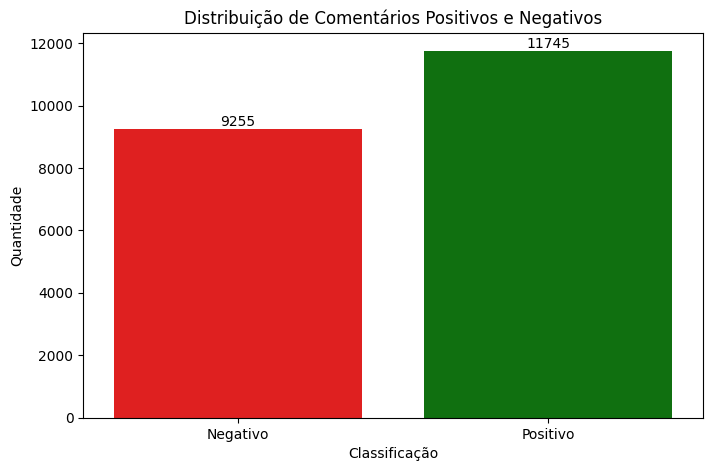

In [84]:
twitte_reviews['classificacao_label'] = twitte_reviews['classificacao'].map({'positivo': 'Positivo', 'negativo': 'Negativo'})

# Criando o gráfico
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='classificacao_label', data=twitte_reviews, palette={'Positivo': 'green', 'Negativo': 'red'})
plt.title('Distribuição de Comentários Positivos e Negativos')
plt.xlabel('Classificação')
plt.ylabel('Quantidade')

# Adicionando anotações com as quantidades exatas
for p in ax.patches:
    ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='bottom', color='black')

plt.show()


**Pré Processamento**

In [96]:
twitte_reviews["text"][1]

'rt @user @user o cara adultera dados, que foram desmascarados e ainda quer ficar no governo?'

In [95]:
twitte_reviews["text"][2]

'@user @user @user o cara só é simplesmente o maior vencedor da história de futebol, tá com 36 anos e tem gás demais e não um gordo com joelho fodido'

In [94]:
twitte_reviews["text"][3]


'eu to chorando vei vsf e eu nem staneio izone nem nada https://t.co/rglb8luutw'

In [89]:
TAG_RE = re.compile(r'<[^>]+>')

def remove_tags(text):
    '''Remover tags HTML: trocando o valor entre <> por espaço em branco'''

    return TAG_RE.sub('', text)

In [90]:
import nltk
nltk.download('stopwords')

# Carregar stopwords em português
stop_words = stopwords.words('portuguese')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [91]:
def preprocess_text(sen):
    '''Cleans text data up, leaving only 2 or more char long non-stepwords composed of A-Z & a-z only
    in lowercase'''

    sentence = sen.lower()


    # Remover pontuações e números
    sentence = re.sub('[^a-zA-Záàâãéèêíïóôõöúçñ]', ' ', sentence)

    # Remover apóstrofos
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Remover múltiplos espaços
    sentence = re.sub(r'\s+', ' ', sentence)

    # Remover Stopwords
    pattern = re.compile(r'\b(' + r'|'.join(stop_words) + r')\b\s*')
    sentence = pattern.sub('', sentence)

    return sentence

In [92]:
#Executando limpeza

X = []
sentences = list(twitte_reviews['text'])
for sen in sentences:
    X.append(preprocess_text(sen))

In [100]:
#testando
X[1]

'rt user user cara adultera dados desmascarados ainda quer ficar governo '

In [104]:
# Convertendo Label do sentimento para 0 e 1

y = twitte_reviews['classificacao']

y = np.array(list(map(lambda x: 1 if x=="positivo" else 0, y)))

In [118]:
#Separando dataset em X e Y de treinameto e validação

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

**Embedding**

Agora criamos um script para nossa camada de embedding. Essa camada servirá para converter o texto em formato numérico. Ela é usada antes da entrada o modelo.

In [119]:
# Usando a função Tokenizer de keras.preprocessing.text
# Metodo fit_on_text treina o tokenizer
# Metodo texts_to_sequences converte a sentença em um formato numérico

tokenizer = Tokenizer(num_words = 10000)

tokenizer.fit_on_texts(X_train)

X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [120]:
vocab_size = len(tokenizer.word_index) + 1

max_len = 100

X_train = pad_sequences(X_train, padding = 'post', maxlen = max_len)
X_test = pad_sequences(X_test , padding = 'post', maxlen = max_len)

In [121]:
# Carrega o word embeddings GloVe e cria o dicinário de Embeddings

embeddings_dictionary = dict()
glove_file = open('glove_s100.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    # Aqui filtramos para garantir que só processamos elementos que podem ser convertidos para float
    filtered_records = [x.replace(',', '.') for x in records[1:] if x.replace('.', '', 1).isdigit()]
    try:
        vector_dimensions = np.asarray(filtered_records, dtype='float32')
        embeddings_dictionary[word] = vector_dimensions
    except ValueError:
        # Se ainda houver algum problema, vamos imprimir a palavra e os registros que falharam
        print(f"Erro na palavra: {word} com registros: {filtered_records}")

glove_file.close()


In [122]:
# Cria uma matriz de Embedding contendo 100 colunas
# 100-dimensional GloVe word embeddings para todas as palavras do corpus.

embedding_matrix = np.zeros((vocab_size, 100))

for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        if len(embedding_vector) < 100:
            # Preenche o vetor com zeros até alcançar 100 dimensões
            embedding_vector = np.pad(embedding_vector, (0, 100 - len(embedding_vector)), 'constant')
        embedding_matrix[index] = embedding_vector


In [123]:
embedding_matrix.shape

(26289, 100)

**Modelo LSTM**

In [125]:
#Arquitetura do modelo

model = Sequential([
    Embedding(vocab_size, 100,  weights=[embedding_matrix], input_length=max_len, trainable=False),
    LSTM(128),
    Dense(1, activation = 'sigmoid')
])



In [126]:
#Parâmetros de Treinamento

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 100, 100)          2628900   
                                                                 
 lstm_2 (LSTM)               (None, 128)               117248    
                                                                 
 dense_2 (Dense)             (None, 1)                 129       
                                                                 
Total params: 2746277 (10.48 MB)
Trainable params: 117377 (458.50 KB)
Non-trainable params: 2628900 (10.03 MB)
_________________________________________________________________
None


In [127]:
history = model.fit(X_train, y_train, batch_size=128, epochs=10, verbose=1, validation_split=0.20)

Epoch 1/10
105/105 [==============================] - 36s 322ms/step - loss: 0.6870 - accuracy: 0.5571 - val_loss: 0.6866 - val_accuracy: 0.5571
Epoch 2/10
105/105 [==============================] - 33s 317ms/step - loss: 0.6868 - accuracy: 0.5583 - val_loss: 0.6868 - val_accuracy: 0.5571
Epoch 3/10
105/105 [==============================] - 33s 317ms/step - loss: 0.6865 - accuracy: 0.5583 - val_loss: 0.6869 - val_accuracy: 0.5571
Epoch 4/10
105/105 [==============================] - 33s 319ms/step - loss: 0.6866 - accuracy: 0.5583 - val_loss: 0.6869 - val_accuracy: 0.5571
Epoch 5/10
105/105 [==============================] - 32s 309ms/step - loss: 0.6865 - accuracy: 0.5583 - val_loss: 0.6866 - val_accuracy: 0.5571
Epoch 6/10
105/105 [==============================] - 33s 319ms/step - loss: 0.6866 - accuracy: 0.5583 - val_loss: 0.6867 - val_accuracy: 0.5571
Epoch 7/10
105/105 [==============================] - 34s 320ms/step - loss: 0.6866 - accuracy: 0.5583 - val_loss: 0.6866 - val_ac

In [54]:
#Evaluate
score = model.evaluate(X_test, y_test, verbose=1)

132/132 [==============================] - 8s 60ms/step - loss: 0.6849 - accuracy: 0.5643


In [55]:
print("Teste Score:", score[0])
print("Teste Accuracy:", score[1])

Teste Score: 0.6849216818809509
Teste Accuracy: 0.5642856955528259


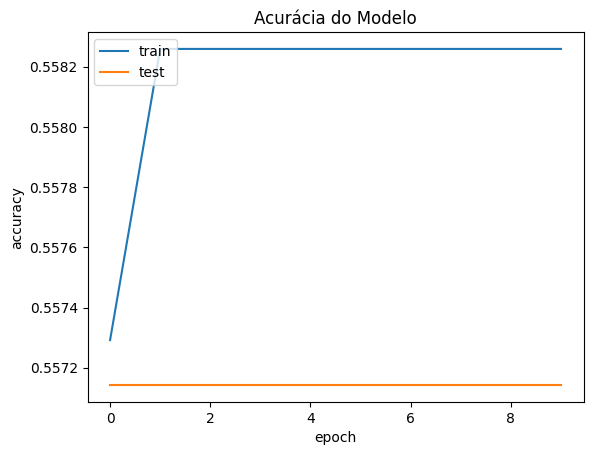

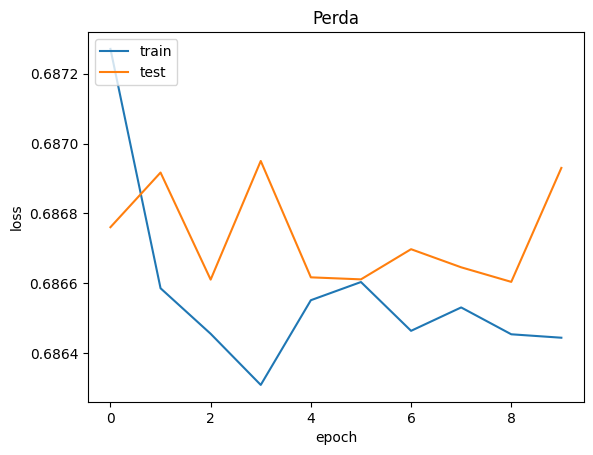

In [56]:
#Gráficos de Avaliação

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

plt.title('Acurácia do Modelo')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.title('Perda')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'], loc='upper left')
plt.show()

In [57]:
# Salvando o modelo em formato h5

model.save(f"./lstm_model_acc_{round(score[1], 3)}.h5", save_format='h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


**Fazendo Predições**

In [70]:
instance = "@user muito dele"
#instance2 = "I was looking forward to Dantes contribution to this excellent horror anthology series from Showtime, but this was easily the worst of the bunch. Its really too bad. Part of this may be due to the poor, if odd, choice of source materials. Why Joe didnt just write an original, I have no idea. Instead, we get this soapbox episode where the ""message"" overwhelms the script, the characters, the staging, everything, and by the end I was just wondering whether it could get any worse, and I wont spoil it...but it ended up getting worse. What a stinker by such a talented creative team. Skip this one and buy the John Carpenter one instead. It manages to balance all of the elements: horror, humor, character, vision, and its fun. Homecoming is about as fun as having a bear take a dump on you while you sleep."

instance = tokenizer.texts_to_sequences(instance)

flat_list = []

for sublist in instance :
    for item in sublist :
        flat_list.append(item)

flat_list = [flat_list]

flat_list = pad_sequences(flat_list, padding = 'post', maxlen = max_len)

if model.predict(flat_list) > 0.5 :

    print("Twitte Positivo")

else :
    print("Twitte Negativo.")

1/1 [==============================] - 0s 122ms/step
Twitte Positivo
